In [7]:
import librosa
import librosa.display

from collections import Counter

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [10]:
# Get meta
PATH_META_DATA = 'UrbanSound8K/metadata/UrbanSound8K.csv'

meta_data = pd.read_csv(PATH_META_DATA)
print('Number of wav files:', meta_data.shape[0])
meta_data.head()

Number of wav files: 8732


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
meta_data = meta_data.sample(frac=1)
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
614,110688-3-0-2.wav,110688,1.000000,5.000000,2,8,3,dog_bark
6806,55018-0-0-116.wav,55018,62.041583,66.041583,1,4,0,air_conditioner
4329,180937-7-1-2.wav,180937,194.415715,198.415715,1,1,7,jackhammer
339,104998-7-18-13.wav,104998,501.891651,505.891651,1,5,7,jackhammer
5439,204773-3-7-1.wav,204773,22.362283,26.362283,1,2,3,dog_bark


In [12]:
AUDIO_PATH = 'UrbanSound8K/audio/fold2/100652-3-0-0.wav'

Sampling rate: 16000


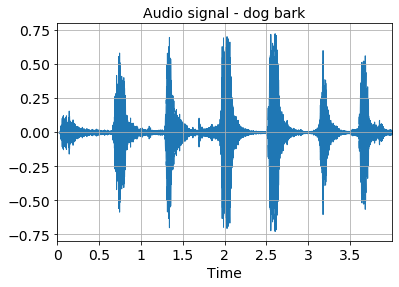

In [15]:
audio_signal, fs = librosa.load(AUDIO_PATH, mono=True, sr=16000)
librosa.display.waveplot(audio_signal, sr=fs)
print('Sampling rate:', fs)
    
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Audio signal - dog bark', fontsize=14)
plt.ylabel("", fontsize=10);plt.xlabel("Time", fontsize=14);
plt.grid()

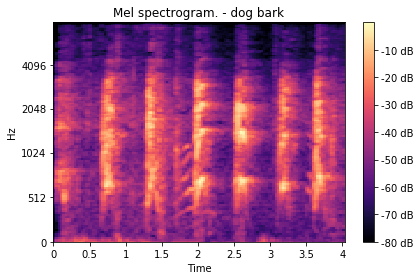

In [16]:
S = librosa.feature.melspectrogram(y=audio_signal, sr=fs, n_mels=128, fmax=fs/2)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=fs, y_axis='mel', fmax=fs/2, x_axis='time')
plt.title('Mel spectrogram. - dog bark')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()


FEATURE ENGINEERING
The audio clips are resampled to a sample rate of 16kHz, and a mono channel is used. In the capstone project no data augmentation is performed. Given the audio clips are less or equal to 4s and the CNN request a fixed length segment the audio clips will be divided into equal length frames using a similar approach as described in Paper (pdf) and Urban Sound Classification Part 2: Applying Convolutional Neural Network. The fixed segments are converted to the Mel spectrogram which is used as feature input for the neural network.

In [17]:
def extract_features(path, filename_list, sample_rate, n_mels):
    """
    Args:
        path: path to the audio files
        filename_list: list of audio files
        sample_rate: target sampling rate
        n_mels: number of Mel bands to generate
    
    Returns:
        specgrams_array: array of melspectrogram in dB 
        labels: labels
    
    """
    clip_lenght = 4
    
    specgrams = []
    labels = []
    
    for file in filename_list:
        sound_clip, sr = librosa.load(path+file, sr=sample_rate)
        # add zero to the audioclip so the total lenght becomes 4 sec
        
        if len(sound_clip) < clip_lenght*sr:
            sound_clip = np.pad(sound_clip, (0, clip_lenght*sr-len(sound_clip)), 'constant')
        
        signal = sound_clip[0:clip_lenght*sample_rate]
        S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmax=sr/2)
        S_dB = librosa.power_to_db(S, ref=np.max)
    
        specgrams.append(S_dB)
        
        labels.append(file.split('-')[1]) 
            
    specgrams_array = np.asarray(specgrams).reshape(len(specgrams),specgrams[0].shape[0],specgrams[0].shape[1])
    
    return specgrams_array, labels

In [18]:

# Parameters
sample_rate = 16000
n_mels = 128

In [20]:
# extract feature of the audio clip and save

for fold_nmb in range(1,11):
    print('fold:', fold_nmb)
    filename_list = list(meta_data.loc[meta_data['fold'] == fold_nmb]['slice_file_name'])
    path = "UrbanSound8K/audio/fold"+str(fold_nmb)+"/"
    
    melspectrogram, labels = extract_features(path, filename_list, sample_rate, n_mels)
    
    np.save("UrbanSound8K/audio/fold/melspectrogram_fold"+str(fold_nmb), melspectrogram)
    np.save("UrbanSound8K/audio/fold/labels_fold"+str(fold_nmb), labels)

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10


PART 2
Read data from disk

In [21]:
import librosa
import librosa.display

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
melspectrogram = []
labels = []

for i in range(1,11):
    melspectrogram.append(np.load("UrbanSound8K/audio/fold/melspectrogram_fold"+str(i)+".npy"))
    labels.append(np.load("UrbanSound8K/audio/fold/labels_fold"+str(i)+".npy"))

PART 3
Train dataset

In [23]:
fold_training = [4, 5, 6, 7, 8, 9, 10]
fold_validation = [2, 3]
fold_test = [1]

In [24]:
melspectrogram_train = (melspectrogram[fold_training[0]-1], melspectrogram[fold_training[1]-1], 
                  melspectrogram[fold_training[2]-1], melspectrogram[fold_training[3]-1], 
                  melspectrogram[fold_training[4]-1], melspectrogram[fold_training[5]-1], 
                  melspectrogram[fold_training[6]-1])
labels_train = (labels[fold_training[0]-1], labels[fold_training[1]-1], labels[fold_training[2]-1],
          labels[fold_training[3]-1], labels[fold_training[4]-1], labels[fold_training[5]-1],
          labels[fold_training[6]-1])

melspectrogram_validation = (melspectrogram[fold_validation[0]-1], melspectrogram[fold_validation[1]-1])
labels_validation = (labels[fold_validation[0]-1], labels[fold_validation[1]-1])
                        
melspectrogram_train = np.concatenate(melspectrogram_train, axis=0)
labels_train = np.concatenate(labels_train, axis=0)

melspectrogram_validation = np.concatenate(melspectrogram_validation, axis=0)
labels_validation = np.concatenate(labels_validation, axis=0)

Standardize features

In [25]:
mean = np.mean(melspectrogram_train, axis = 0)
std = np.std(melspectrogram_train, axis = 0)

X_train_stand_score = (melspectrogram_train-mean)/std
X_val_stand_score = (melspectrogram_validation-mean)/std 
X_test_stand_score = (melspectrogram[fold_test[0]-1]-mean)/std

Neural Network
Convolution Neural Network

In [26]:
import keras
print(keras.__version__)

from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

from keras.regularizers import l1
from keras.regularizers import l2

from keras.utils import to_categorical

from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import LeakyReLU

from keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import itertools

2.4.3


In [27]:
# ref.: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [28]:
def network(model, epochs, batch_size, lr):
    
    opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(X_val, y_val))
    
    history_dict = history.history
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    print('')
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'bx-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.clf()   # clear figure
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'bx-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    print('')
    print('Test accurancy:')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('', 100*test_acc, '%')
    
    print('')
    y_pred = model.predict(X_test)

    classID = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    classes = ['air conditioner', 'car horn', 'children playing', 'dog bark', 
           'drilling','engine idling', 'gun shot', 'jackhammer', 'siren', 'street music']

    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classID)
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)

    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(matrix, classes=classes, normalize=True, title='Normalized confusion matrix')
    print("Test accuracy = " + str(100*accuracy))

Preparing the train, test and validation data

In [29]:
X_train = X_train_stand_score.reshape((X_train_stand_score.shape[0], X_train_stand_score.shape[1], X_train_stand_score.shape[2], 1))
X_test = X_test_stand_score.reshape((X_test_stand_score.shape[0], X_test_stand_score.shape[1], X_test_stand_score.shape[2], 1))
X_val = X_val_stand_score.reshape((X_val_stand_score.shape[0], X_val_stand_score.shape[1], X_val_stand_score.shape[2], 1))

Preparing the labels

In [30]:
y_train = to_categorical(labels_train)
y_val = to_categorical(labels_validation)
y_test = to_categorical(labels[fold_test[0]-1])

CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 124, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 126, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 122, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 124, 122, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 484096)            0         
_________________________________________________________________
dense (Dense)                (None, 125)               60512125  
_________________________________________________________________
activation_2 (Activation)    (None, 125)               0

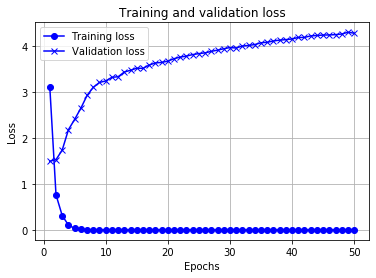

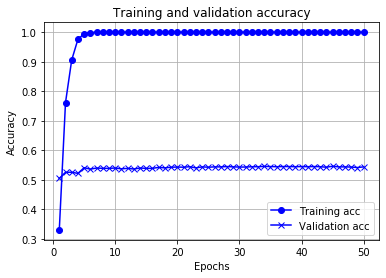


Test accurancy:
28/28 [==============================] - 4s 147ms/step - loss: 4.3426 - accuracy: 0.5624
 56.242841482162476 %

Normalized confusion matrix
[[0.13 0.01 0.11 0.   0.02 0.06 0.   0.34 0.26 0.07]
 [0.   0.81 0.   0.06 0.   0.   0.14 0.   0.   0.  ]
 [0.03 0.   0.73 0.07 0.01 0.01 0.   0.   0.06 0.09]
 [0.01 0.05 0.14 0.77 0.   0.   0.   0.01 0.   0.02]
 [0.08 0.   0.04 0.02 0.56 0.04 0.06 0.18 0.   0.02]
 [0.07 0.03 0.03 0.   0.   0.48 0.   0.   0.38 0.01]
 [0.   0.   0.   0.09 0.06 0.   0.8  0.06 0.   0.  ]
 [0.02 0.03 0.01 0.   0.52 0.03 0.   0.33 0.06 0.01]
 [0.07 0.   0.17 0.   0.01 0.   0.   0.   0.71 0.03]
 [0.03 0.06 0.09 0.   0.04 0.02 0.   0.04 0.04 0.68]]
Test accuracy = 56.24284077892325
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/Baseline_CNN\assets


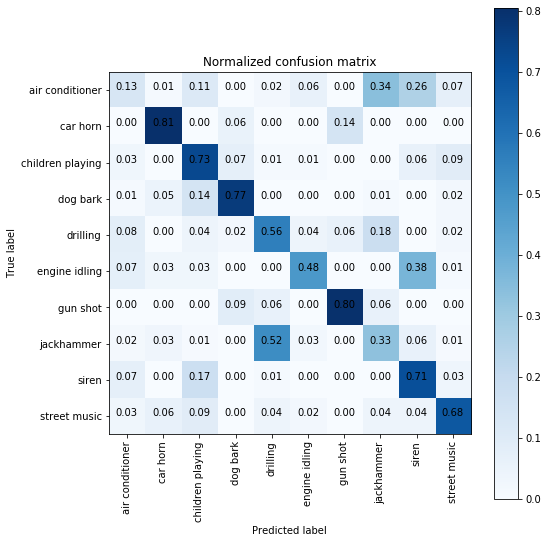

In [31]:
filename_model = 'Baseline_CNN'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10

keras.backend.clear_session()

baseline_model = models.Sequential()
baseline_model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels)))
baseline_model.add(Activation('relu'))
baseline_model.add(Conv2D(32, (3,3)))
baseline_model.add(Activation('relu'))
baseline_model.add(Flatten())
baseline_model.add(Dense(125))
baseline_model.add(Activation('relu'))
baseline_model.add(Dense(125))
baseline_model.add(Activation('relu'))
baseline_model.add(Dense(10,activation ='softmax'))

baseline_model.summary()

network(baseline_model, 50, 125, 0.001)
baseline_model.save('./model/'+filename_model)



In [ ]:
filename_model = 'CNN2'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (1,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (1,3), padding='same'))
model.add(MaxPooling2D((1,2), strides=2))
model.add(Activation('relu'))

model.add(Conv2D(32, (6,1), padding='same'))
model.add(Conv2D(32, (6,1), padding='same'))
model.add(MaxPooling2D((4,1), strides=2))
model.add(Activation('relu'))        

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)